In [1]:
"""zero shot segmentation using segnet"""
# imports without torch
import numpy as np
import argparse
import os
import os.path
import visdom
from PIL import Image
from tqdm import tqdm
import json
import sys

##########
# imports torch
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
##########

# imports models
import model.segnet as segnet
import model.encoder as encoder  # label->word
import model.decoder as decoder  # word->label
import zs_dataset_list as datasets

# imports utility
import make_log as flog

In [2]:
class p_args:
    load=True
    config="MSE_batch12"
    test=True
    no_cuda=False
    cuda=True
    
f_config = open(os.path.join("./config", p_args.config + ".json"), "r")
args = json.load(f_config)
for key, value in args.items():
    if value == "true":
        args[key] = True
    elif value == "false":
        args[key] = False
print(args)

# device settings
USE_CUDA = True

# data settings
if args["model"] is True and args["encoder"] is True:
    input_nbr = args["input_nbr"]  # 入力次元数
    semantic_nbr = args["semantic_nbr"]  # 特徴次元数
    target_nbr = args["target_nbr"]  # 出力次元数
elif args["model"] is True and args["decoder"] is True:
    input_nbr = args["input_nbr"]  # 入力次元数
    semantic_nbr = args["semantic_nbr"]  # 特徴次元数
    target_nbr = args["target_nbr"]  # 出力次元数
else:
    input_nbr = args["input_nbr"]  # 入力次元数
    target_nbr = args["target_nbr"]  # 出力次元数

# set the seed
torch.manual_seed(args["seed"])
if p_args.cuda:
    torch.cuda.manual_seed(args["seed"])

# create models
"""
(1)model and decoder(SSE is False)
SegNet(input_nbr, semantic_nbr)
ConvNet(semantic_nbr, target_nbr)
(2)model and decoder(SSE is True)
SegNet(input_nbr, target_nbr)
ConvNet(semantic_nbr, target_nbr)
(3)model only
SegNet(input_nbr, target_nbr)
(4)decoder only
ConvNet(input_nbr, target_nbr)
(5)encoder only
ConvNet(input_nbr, target_nbr)
"""

if args["model"] is True and args["decoder"] is True:
    if args["SSE"] is False:
        """(1)"""
        model = segnet.SegNet(input_nbr, semantic_nbr, args["momentum"])
        head = decoder.ConvNet(semantic_nbr, target_nbr, args["momentum"])
    else:
        """(2)"""
        model = segnet.SegNet(input_nbr, target_nbr, args["momentum"])
        head = decoder.ConvNet(semantic_nbr, target_nbr, args["momentum"])
elif args["model"] is True:
    """(3)"""
    model = segnet.SegNet(input_nbr, target_nbr, args["momentum"])
elif args["decoder"] is True:
    """(4)"""
    head = decoder.ConvNet(input_nbr, target_nbr, args["momentum"])
elif args["encoder"] is True:
    """(5)"""
    head = encoder.ConvNet(input_nbr, target_nbr, args["momentum"])
else:
    sys.exit("model is not defined")
if args["model"] is True:
    if USE_CUDA:  # convert to cuda if needed
        model.cuda()
    else:
        model.float()
        model.cpu()
    model.eval()
    print(model)
if args["encoder"] is True or args["decoder"] is True:
    if USE_CUDA:  # convert to cuda if needed
        head.cuda()
    else:
        head.float()
        head.cpu()
    head.eval()
    print(head)

# Create visdom
vis = visdom.Visdom()

# init window
if p_args.test is False:
    if args["encoder"] is True or args["decoder"] is True:
        """encoder or decoder"""
        win = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='train_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )
    else:
        """model"""
        win = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='train_loss',
                xlabel='epoch',
                ylabel='loss',
                ytickmin=0.0,
                ytickmax=1.0,
                width=800,
                height=400
            )
        )
    win_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_accuracy',
            xlabel='epoch',
            ylabel='accuracy',
            width=800,
            height=400
        )
    )

# Create log model
f_log = flog.make_log(args["project_dir"])

# define the optimizer
if args["encoder"] is True or args["decoder"] is True:
    optimizer = optim.Adam(head.parameters(), lr=args["lr"])
else:
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])

{'model': True, 'encoder': False, 'decoder': False, 'input_nbr': 3, 'target_nbr': 100, 'semantic_nbr': 0, 'batch_size': 12, 'epochs': 10, 'lr': 0.0001, 'momentum': 0.1, 'seed': 1, 'lamda': 0, 'gamma': 1, 'input_root': './data/train/input', 'target_root': './data/train/zs_target', 'map_root': './data/train/target', 'filenames': './data/train/zs_names.txt', 'semantic_filename': './v_class/class1.txt', 'project_dir': './model/MSE_batch12', 'model_load_pth': './model/MSE_batch12/segnet.pth', 'head_load_pth': '', 'save_pth': 'segnet.pth', 'output_dir': './data/MSE_batch12', 'n_components': 100, 'PCA': False, 'cos_similarity': False, 'jaccard_similarity': False, 'ZSL': True, 'SSE': False}
SegNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [3]:
def model_train(epoch, trainloader):
    # set model to train mode
    model.train()

    # define a loss
    # 今回の場合背景クラスを考慮しないので重み付けはしない
    if USE_CUDA:
        loss = nn.MSELoss(size_average=True).cuda()
        l1_loss = nn.L1Loss(size_average=False).cuda()
    else:
        loss = nn.MSELoss(size_average=True)
        l1_loss = nn.L1Loss(size_average=False)

    # define total_loss
    total_loss = 0

    # define epoch_size
    epoch_size = len(trainloader)

    # define batch_loss
    batch_loss = 0

    # define lamda
    lamda = args["lamda"]

    # define annotations
    v_array = trainloader.dataset.v_array
    if args["ZSL"] is True:
        GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
                   149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102,
                   175, 99]
        v_array = v_array[GT_list]
    v_array = torch.from_numpy(v_array)
    if USE_CUDA:
        v_array = v_array.cuda()

    # iteration over the batches
    for batch_id, data in enumerate(trainloader):
        # make batch tensor and target tensor
        input = data['input']
        target = data['target']
        mask = data['mask']

        if USE_CUDA:
            input = input.cuda()
            target = target.cuda()
            mask = mask.cuda()

        # initialize gradients
        optimizer.zero_grad()

        # predictions
        output = model(input)

        # mask tensor
        output = output * mask
        target = target * mask

        # calculate loss
        l_ = loss(output, target)
        l_ = l_ * output.size(1)
        if lamda != 0:
            reg_loss = 0
            for param in model.parameters():
                if USE_CUDA:
                    param_target = Variable(torch.zeros(param.size())).cuda()
                else:
                    param_target = Variable(torch.zeros(param.size()))
                reg_loss += l1_loss(param, param_target)

            reg_loss = lamda * reg_loss
            l_ += l_ + reg_loss

        total_loss += l_.item()
        # backward loss
        l_.backward()
        # optimizer step
        optimizer.step()

        # train conditions
        if lamda != 0:
            print("epoch=%d, id=%d, reg_loss=%f, loss=%f" %
                  (epoch, batch_id, reg_loss.item(), l_.item()))
        else:
            print("epoch=%d, id=%d, loss=%f" %
                  (epoch, batch_id, l_.item()))

        # visualize train conditions
        if batch_id % 30 == 0 and batch_id != 0:
            batch_loss = batch_loss + l_.item()
            batch_loss = batch_loss / 30
            # display visdom board
            phase = epoch + batch_id / epoch_size
            visualize(phase, batch_loss, win)
            batch_loss = 0
            # evaluate
            target_map = data["map"]
            model.eval()
            output = model(input)
            model_evaluate(output, target_map, v_array,
                           epoch, epoch_size, batch_id)
            model.train()
        else:
            batch_loss = batch_loss + l_.item()

    return total_loss


def head_train(epoch, trainloader):
    # set head to train mode
    if args["model"] is True:
        model.eval()
        head.train()
    else:
        head.train()

    # define total_loss
    total_loss = 0

    # define epoch_size
    epoch_size = len(trainloader)

    # define batch_loss
    batch_loss = 0

    # define lamda,gamma
    lamda = args["lamda"]
    gamma = args["gamma"]

    # define annotations
    v_array = trainloader.dataset.v_array
    if args["ZSL"] is True:
        GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
                   149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102, 175,
                   99]
        v_array = v_array[GT_list]
        v_array = torch.from_numpy(v_array)
    elif args["SSE"] is True:
        v_array = torch.from_numpy(v_array)
        v_array_copy = v_array.clone()
        for i in range(args["batch_size"] - 1):
            if i == 0:
                v_array = torch.cat([v_array[None, :], v_array_copy[None, :]],
                                    dim=0)
            else:
                v_array = torch.cat([v_array, v_array_copy[None, :]], dim=0)
    else:
        v_array = torch.from_numpy(v_array)
    if USE_CUDA:
        v_array = v_array.cuda()

    # define output_vector target
    output_target = torch.zeros((v_array.shape[0], v_array.shape[1]))
    if USE_CUDA:
        output_target = output_target.cuda()

    # define a loss
    if USE_CUDA:
        if args["encoder"] is True and args["SSE"] is False:
            """encoder (SSE is False)"""
            loss = nn.MSELoss(size_average=True).cuda()
        elif args["decoder"] is True and args["SSE"] is False:
            """decoder (SSE is False)"""
            loss = nn.CrossEntropyLoss(size_average=True).cuda()
        elif args["decoder"] is True and args["SSE"] is True:
            """decoder (SSE is True)"""
            loss = nn.MSELoss(size_average=True).cuda()
            MSE_loss = nn.MSELoss(size_average=False).cuda()
        else:
            sys.exit("model is not defined")
        l1_loss = nn.L1Loss(size_average=False).cuda()
    else:
        if args["encoder"] is True and args["SSE"] is False:
            """encoder (SSE is False)"""
            loss = nn.MSELoss(size_average=True)
        elif args["decoder"] is True and args["SSE"] is False:
            """decoder (SSE is False)"""
            loss = nn.CrossEntropyLoss(size_average=True)
        elif args["decoder"] is True and args["SSE"] is True:
            """decoder (SSE is True)"""
            loss = nn.MSELoss(size_average=True)
            MSE_loss = nn.MSELoss(size_average=False)
        else:
            sys.exit("model is not defined")
        l1_loss = nn.L1Loss(size_average=False)

    # iteration over the batches
    for batch_id, data in enumerate(trainloader):
        # make batch tensor and target tensor
        if args["model"] is True and args["decoder"] is True and args["SSE"] is False:
            input = data["input"]
            target = data["target"]
            mask1 = data["mask1"]
            mask2 = data["mask2"]
        elif args["decoder"] is True and args["SSE"] is False:
            input = data["input"]
            target = data["target"]
        elif args["decoder"] is True and args["SSE"] is True:
            input = data["input"]
        elif args["encoder"] is True and args["SSE"] is False:
            input = data["input"]
            target = data["target"]
        else:
            sys.exit("model is not defined")

        if USE_CUDA:
            if args["model"] is True and args["decoder"] is True and args["SSE"] is False:
                input = input.cuda()
                target = target.cuda()
                mask1 = mask1.cuda()
                mask2 = mask2.cuda()
            elif args["decoder"] is True and args["SSE"] is False:
                input = input.cuda()
                target = target.cuda()
            elif args["decoder"] is True and args["SSE"] is True:
                input = input.cuda()
            elif args["encoder"] is True and args["SSE"] is False:
                input = input.cuda()
                target = target.cuda()

        # initialize gradients
        optimizer.zero_grad()

        # predictions
        if args["model"] is True and args["decoder"] is True and args["SSE"] is False:
            semantic = model(input)
            output = head(semantic)
            # mask tensor
            target = target * mask1
            output = output * mask2
        else:
            output = head(input)

        # calculate loss
        if args["SSE"] is False:
            """SSE is False"""
            l_ = loss(output, target)
            if lamda != 0:
                reg_loss = 0
                for param in head.parameters():
                    if USE_CUDA:
                        param_target = torch.zeros(param.size()).cuda()
                    else:
                        param_target = torch.zeros(param.size())
                    reg_loss += l1_loss(param, param_target)

                reg_loss = lamda * reg_loss
                l_ = l_ + reg_loss
        else:
            """SSE is True"""
            # maxmize similarity loss
            l_1 = 0
            for i in range(v_array.shape[0]):
                v_array2 = v_array[:, i, :]
                output2 = output[:, i, 0, 0][:, None]
                target = v_array2 * output2
                l_1 += loss(input[:, :, 0, 0], target.detach())
            # minimize vector norm loss
            l_2 = MSE_loss(output[:, :, 0, 0], output_target)
            l_2 = gamma * l_2
            # minimize parameter norm loss
            l_3 = 0
            if lamda != 0:
                reg_loss = 0
                for param in head.parameters():
                    if USE_CUDA:
                        param_target = torch.zeros(param.size()).cuda()
                    else:
                        param_target = torch.zeros(param.size())
                    reg_loss += l1_loss(param, param_target)

                reg_loss = lamda * reg_loss
                l_3 = reg_loss

            l_ = l_1 + l_2 + l_3

        total_loss += l_.item()
        # backward loss
        l_.backward()
        # optimizer step
        optimizer.step()

        # train conditions
        if lamda != 0:
            print("epoch=%d, id=%d, reg_loss=%f, loss=%f" %
                  (epoch, batch_id, reg_loss.item(), l_.item()))
        else:
            print("epoch=%d, id=%d, loss=%f" %
                  (epoch, batch_id, l_.item()))

        # visualize train conditions
        if batch_id % 30 == 0 and batch_id != 0:
            batch_loss = batch_loss + l_.item()
            batch_loss = batch_loss / 30
            # display visdom board
            phase = epoch + batch_id / epoch_size
            visualize(phase, batch_loss, win)
            batch_loss = 0
            # evaluate
            if args["decoder"] is True and args["SSE"] is False:
                """decoder only"""
                head.eval()
                if args["model"] is True:
                    target = data["map"]
                    output = head(semantic)
                else:
                    output = head(input)
                head_evaluate(output, target, epoch, epoch_size, batch_id)
                head.train()
        else:
            batch_loss = batch_loss + l_.item()

    return total_loss




def head_test(testloader):
    """decoder only (SSE is False)"""
    # set head to eval mode
    if args["model"] is True:
        model.eval()
        head.eval()
    else:
        head.eval()

    # define annotations
    v_array = testloader.dataset.v_array
    if args["ZSL"] is True:
        GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
                   149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102,
                   175, 99]
        GT_num = len(GT_list)
        v_array = v_array[GT_list]
    v_array = torch.from_numpy(v_array)
    if USE_CUDA:
        v_array = v_array.cuda()

    # make output_dir
    if not os.path.isdir(args["output_dir"]):
        os.makedirs(args["output_dir"])

    # iteration over the batches
    for batch_id, data in enumerate(testloader):
        # make batch tensor and target tensor
        input = data['input']

        if USE_CUDA:
            input = input.cuda()

        if args["model"] is True and args["decoder"] is True and args["SSE"] is False:
            """model and decoder (SSE is False)"""
            # predictions
            semantic = model(input)
            output = head(semantic)
            # make result
            filename = os.path.basename(
                testloader.dataset.get_filename(batch_id)[0])
            filename = filename.split(".")[0]
            filename = filename + ".png"
            print(filename)
            single_output = output[0, :, :, :]
            if args["ZSL"] is True:
                for i in range(GT_num):
                    if i == 0:
                        result = single_output[GT_list[i], :, :][None, :, :]
                    else:
                        result = torch.cat(
                            [result, single_output[GT_list[i], :, :]
                             [None, :, :]], dim=0)
        elif args["decoder"] is True and args["SSE"] is False:
            """decoder"""
            # predictions
            output = head(input)
            # make result
            if batch_id < 10:
                filename = '00' + str(batch_id) + '.png'
            elif batch_id < 100:
                filename = '0' + str(batch_id) + '.png'
            else:
                filename = str(batch_id) + '.png'
            print(filename)
            result = output[0, :, :, :]
        else:
            sys.exit("model is not defined")

        # output segmentation_img
        result = result.max(0)[1].cpu().numpy()
        if args["ZSL"] is True:
            img1 = result.copy()
            for i in range(GT_num):
                result[img1 == i] = GT_list[i]
        result = np.uint8(result)
        Image.fromarray(result).save(
            os.path.join(args["output_dir"], filename))


def model_evaluate(output, target_map, v_array, epoch, epoch_size, batch_id):
    data_num = 0
    correct_num = 0
    """
    # calculate normal accuracy
    data_num2 = 0
    correct_num2 = 0
    """
    GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
               149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102, 175, 99]
    GT_root = np.ones(target_map[0, :, :].shape, dtype='int32')
    GT_num = len(GT_list)
    print("evaluating ...")
    for id in tqdm(range(output.size(0))):
        single_output = output[id, :, :, :]
        target = target_map[id, :, :].cpu().numpy()
        single_output = single_output.transpose(0, 1).transpose(1, 2)
        result = min_euclidean(single_output, v_array).cpu().numpy()
        single_data_num, single_correct_num = evaluate_(
            target, result, GT_root, GT_list, GT_num)
        data_num += single_data_num
        correct_num += single_correct_num
        """
        # calculate normal accuracy
        img = np.ones(target.shape)
        img[target >= 182] = 0
        data_num2 += np.sum(img)
        img = result - target
        img2 = np.zeros(target.shape)
        img2[img == 0] = 1
        correct_num2 += np.sum(img2)
        """

    phase = epoch + batch_id / epoch_size
    if data_num == 0:
        visualize(phase, 0, win_acc)
        print("train_acc = %f" % (correct_num / data_num))
        print("GT is null")
    else:
        visualize(phase, (correct_num / data_num), win_acc)
        print("train_acc = %f" % (correct_num / data_num))


def head_evaluate(output, target_map, epoch, epoch_size, batch_id):
    """decoder only (SSE is False)"""
    data_num = 0
    correct_num = 0
    GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
               149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102, 175, 99]
    GT_root = np.ones(target_map[0, :, :].shape, dtype='int32')
    GT_num = len(GT_list)
    print("evaluating ...")
    if args["model"] is True and args["decoder"] is True and args["SSE"] is False:
        """model and decoder (SSE is False)"""
        for id in range(output.size(0)):
            single_output = output[id, :, :, :]
            if args["ZSL"] is True:
                for i in range(GT_num):
                    if i == 0:
                        single_output2 = single_output[GT_list[i],
                                                       :, :][None, :, :]
                    else:
                        single_output2 = torch.cat(
                            [single_output2, single_output[GT_list[i], :, :]
                             [None, :, :]], dim=0)
                single_output = single_output2
            target = target_map[id, :, :].cpu().numpy()
            result = single_output.max(0)[1].cpu().numpy()
            single_data_num, single_correct_num = evaluate_(
                target, result, GT_root, GT_list, GT_num)
            data_num += single_data_num
            correct_num += single_correct_num
    elif args["decoder"] is True and args["SSE"] is False:
        """decoder"""
        for id in range(output.size(0)):
            single_output = output[id, :, :, :]
            target = target_map[id, :, :].cpu().numpy()
            result = single_output.max(0)[1].cpu().numpy()
            # calculate normal accuracy
            img = np.ones(target.shape)
            data_num += np.sum(img)
            img = result - target
            img2 = np.zeros(target.shape)
            img2[img == 0] = 1
            correct_num += np.sum(img2)
    else:
        sys.exit("model is not defined")

    phase = epoch + batch_id / epoch_size
    if data_num == 0:
        visualize(phase, 0, win_acc)
        print("train_acc = %f" % (correct_num / data_num))
        print("GT is null")
    else:
        visualize(phase, (correct_num / data_num), win_acc)
        print("train_acc = %f" % (correct_num / data_num))


def evaluate_(target_img, predict_img, GT_root, GT_list, GT_num):
    GT_pixel_num = 0
    predict_TP_num = 0
    for i in range(GT_num):
        GT = GT_root * GT_list[i]
        img1 = target_img - GT
        if args["ZSL"] is True:
            img2 = predict_img - i
        else:
            img2 = predict_img - GT
        img1c = img1.copy()
        img2c = img2.copy()
        img1[img1c == 0] = 1
        img1[img1c != 0] = 0
        img2[img2c == 0] = 1
        img2[img2c != 0] = 0
        img3 = img1 + img2
        img3c = img3.copy()
        img3[img3c == 2] = 1
        img3[img3c != 2] = 0
        GT_pixel_num += np.sum(img1)
        predict_TP_num += np.sum(img3)

    return GT_pixel_num, predict_TP_num


def visualize(phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )


def min_euclidean(out, sem):
    """pytorch calculate euclidean"""
    nbr = sem.size(1)
    ab = torch.mm(out.view(-1, nbr), sem.t())
    ab = ab.view(out.size(0), out.size(1), sem.size(0))
    aa = (sem**2).sum(1)
    bb = (out**2).sum(-1)
    res = aa[None, None, :] + bb[:, :, None] - 2 * ab
    return res.min(-1)[1]


def min_euclidean2(out, sem):
    """numpy calculate euclidean"""
    ab = np.dot(out, sem.transpose())
    aa = (sem**2).sum(1)
    bb = (out**2).sum(-1)
    res = aa[None, None, :] + bb[:, :, None] - 2 * ab
    return res.argmin(-1)


def main():
    # compose transforms
    train_transform = transforms.Compose(
        [transforms.RandomResizedCrop(256, scale=(1.0, 1.0),
                                      ratio=(1.0, 1.0),
                                      interpolation=Image.NEAREST)]
    )
    test_transform = transforms.Compose(
        []
    )

    # initialize model
    if args["model"] is True:
        model.initialized_with_pretrained_weights()

    # load model
    if p_args.load is True:
        if args["model"] is True:
            model.load_from_filename("./model/MSE_batch12/segnet.pth")
        if args["encoder"] is True or args["decoder"] is True:
            head.load_from_filename(args["head_load_pth"])

    # load dataset
    if args["model"] is True and args["SSE"] is True:
        SSE_decoder = head.load_form_filename(args["head_load_pth"])
    else:
        SSE_decoder = None
    trainset = datasets.ImageFolderDenseFileLists(
        input_root=args["input_root"], target_root=args["target_root"],
        map_root=args["map_root"], filenames=args["filenames"],
        semantic_filename=args["semantic_filename"], training=True,
        model=SSE_decoder, config=args, transform=train_transform,
        USE_CUDA=USE_CUDA)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=args["batch_size"], shuffle=True,
        num_workers=args["batch_size"])
    testset = datasets.ImageFolderDenseFileLists(
        input_root='./data/test/input', target_root=None,
        map_root=None, filenames='./data/test/names.txt',
        semantic_filename=args["semantic_filename"], training=False,
        model=SSE_decoder, config=args, transform=test_transform,
        USE_CUDA=USE_CUDA)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False, num_workers=1)

    # train and test
    for epoch in range(0, args["epochs"]):
        print()
        print("epoch:%d" % (epoch))

        if p_args.test is False:
            # training
            if args["model"] is True and args["decoder"] is True and args["SSE"] is True:
                loss = model_train(epoch, trainloader)
                print("model_loss:%f" % (loss))
            elif args["encoder"] is True or args["decoder"] is True:
                loss = head_train(epoch, trainloader)
                print("head_loss:%f" % (loss))
            else:
                loss = model_train(epoch, trainloader)
                print("model_loss:%f" % (loss))
            print(3)
            # open log_file
            f_log.open()
            # write log_file
            f_log.write(epoch, loss)
            # close log_file
            f_log.close()
            # make project_dir
            if not os.path.isdir(args["project_dir"]):
                os.makedirs(args["project_dir"])
            # save checkpoint
            if args["model"] is True and args["decoder"] is True and args["SSE"] is True:
                torch.save(model.state_dict(),
                           args["project_dir"] + "/checkpoint_" + str(epoch) +
                           ".pth")
            elif args["encoder"] is True or args["decoder"] is True:
                torch.save(head.state_dict(),
                           args["project_dir"] + "/checkpoint_" + str(epoch) +
                           ".pth")
            else:
                torch.save(model.state_dict(),
                           args["project_dir"] + "/checkpoint_" + str(epoch) +
                           ".pth")
        elif p_args.test is True and p_args.load is True:
            # test
            if args["model"] is True and args["decoder"] is True and args["SSE"] is True:
                model_test(testloader)
            elif args["encoder"] is True or args["decoder"] is True:
                head_test(testloader)
            else:
                model_test(testloader)
            break
        else:
            print('can not test the model!')
            break
    # save model
    if p_args.test is False:
        if args["model"] is True and args["decoder"] is True and args["SSE"] is True:
            torch.save(model.state_dict(), os.path.join(
                args["project_dir"], args["save_pth"]))
        elif args["encoder"] is True or args["decoder"] is True:
            torch.save(head.state_dict(), os.path.join(
                args["project_dir"], args["save_pth"]))
        else:
            torch.save(model.state_dict(), os.path.join(
                args["project_dir"], args["save_pth"]))

In [7]:
testset = datasets.ImageFolderDenseFileLists(
        input_root='./data/test/input', 
        target_root=None,
        map_root=None, 
        filenames='./data/test/names.txt',
        semantic_filename=args["semantic_filename"], 
        training=False,
        model=None, 
        config=args, 
        transform=lambda x:x,
        USE_CUDA=True)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=1)

model.load_from_filename('./model/MSE_batch12/segnet.pth')

 11%|█         | 539/5000 [00:00<00:00, 5386.23it/s]

makeing dataset ...


100%|██████████| 5000/5000 [00:00<00:00, 9447.66it/s]


load weights from segnet.pth


In [108]:
model.eval()
v_array = testloader.dataset.v_array

GT_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
           149, 105, 123, 112, 127, 152, 167, 109, 179, 116, 102,
           175, 99]

remove_list = [35, 26, 23, 9, 1, 83, 77, 72, 61, 51, 43, 154, 148,
               149, 105, 123, 112, 127, 152, 167, 109, 179, 116,
               102, 175, 99]
seen_index = [i for i in range(v_array.shape[0]) if i not in remove_list]

v_array = v_array[seen_index]
v_array = torch.from_numpy(v_array).cuda()
lblist = np.array(seen_index, dtype="uint8")

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

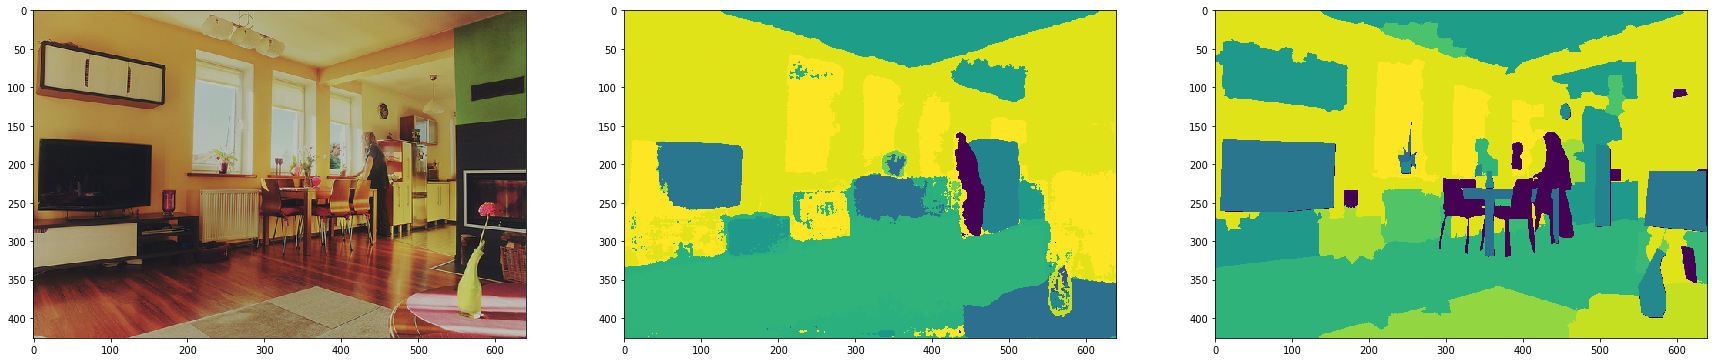

In [32]:
it = iter(testloader)
data = next(it)
x = data["input"]

img = x.squeeze().permute(1,2,0).numpy()
result = _train_seg(x)

filena2me = os.path.basename(
        testloader.dataset.get_filename(0)[0])
filename = filename.split(".")[0]
filename = filename + ".png"
labels = np.array(Image.open("./data/test/target/" + filename))

labels[~np.isin(labels, lblist)]=0
result[~np.isin(labels, lblist)]=0

fig,axes = plt.subplots(1,3, figsize=(30,10))
axes[0].imshow(img)
axes[1].imshow(result)
axes[2].imshow(labels)

In [53]:
testloader.dataset.get_filename(0)[0].replace("input", "target")

'./data/test/target/000000000139.jpg'

In [66]:
trseg[0,0], labels[0,0]

(171, 171)

In [64]:
(trseg[~np.isin(labels, GT_list)]==labels[~np.isin(labels, GT_list)]).mean()

0.5913527962996336

In [100]:
def gfts():
    """
        Retur the first sample of testloader
    """
    return next(iter(testloader))["input"]

def th_to_np(x):
    """
        Transforms pytorch tensor to numpy array for visu
    """
    return x.squeeze().permute(1,2,0).numpy()

def get_lbl(i):
    filename = testloader.dataset.get_filename(i)[0].replace("input", "target")[:-4] + ".png"
    return np.array(Image.open(filename))

def make_cmap():
    cmap = np.random.random((256,3))
    cmap[0]=0
    return cmap

In [101]:
np.unique(te_seg)

array([ 4,  5,  6,  7,  8, 10, 12, 14, 15, 17, 20, 21, 22, 23, 24, 25, 26])

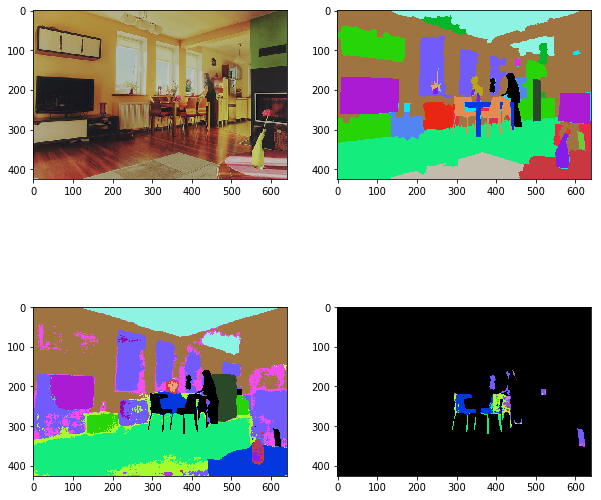

In [114]:
x = gfts()
labels = get_lbl(0)
img = th_to_np(x)

trseg = train_seg(x)
teseg = tr_map_te[trseg]
GT_list = np.array(GT_list)
teseg = GT_list[teseg]

results_tr = trseg.copy()
results_te = trseg.copy()
msk = np.isin(labels, GT_list)
results_tr[msk]=0
results_te[~msk]=0

fig,axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img)
axes[0,1].imshow(cmap[labels])
axes[1,0].imshow(cmap[results_tr])
axes[1,1].imshow(cmap[results_te])

In [115]:
#type(GT_list)
#GT_list[[4,5]]
(results_te[msk]==labels[msk]).mean()

0.25065328734190445

In [1]:
import tqdm

accuracy_tr = []
accuracy_te = []

for i,data in tqdm.tqdm(enumerate(testloader)):
    x = data["input"]
    
    trseg = train_seg(x)
    teseg = tr_map_te[trseg]

    filename = testloader.dataset.get_filename(i)[0].replace("input", "target")[:-4] + ".png"
    labels = np.array(Image.open(filename))
    labels#[~np.isin(labels, GT_list)]=0

    results_tr = trseg.copy()
    results_te = trseg.copy()
    
    msk = np.isin(labels, GT_list)
    acc_te = (results_te[msk]==labels[msk]).mean()
    acc_tr = (results_tr[~msk]==labels[~msk]).mean()
    
    accuracy_tr.append(acc_tr)
    accuracy_te.append(acc_te)

NameError: name 'testloader' is not defined

In [121]:
acc_tr = np.asarray(accuracy_tr)
np.mean(acc_tr[~np.isnan(acc_tr)])

0.4505993385969889

In [118]:
acc_te = np.asarray(accuracy_te)
np.mean(acc_te[~np.isnan(acc_te)])

0.317416041793739

In [88]:
#plt.imshow(msk)

In [85]:
#trseg.min(), labels.min(), trseg.max(), labels.max()

In [49]:
def train_seg(x):
    """
        Segment image x among TRAING CLASSES
        Input x = torch.cuda.FloatTensor: (1,3,h,w)
        Output  = Training class index per pixel
                  torch.cuda.LongTensor : [tridx](h,w)
    """
    output = model(x.cuda())
    single_output = output[0, :, :, :].permute(1,2,0)
    result = min_euclidean(single_output, v_array)
    result = lblist[result]
    return result

def test_seg(x):
    tr_seg = train_seg(x)
    return tr_map_te[tr_seg]

In [ ]:
import tqdm

accuracy_tr = []
accuracy_hi = []
accuracy_we = []

for i,data in tqdm.tqdm(enumerate(testloader)):
    x = data["input"]
    img = x.squeeze().permute(1,2,0).numpy()
    
    trseg = train_seg(x)
    single_output = output[0, :, :, :].permute(1,2,0)
    result = min_euclidean(single_output, v_array).cpu().numpy()
    result = lblist[result]
    
    filename = os.path.basename(
            testloader.dataset.get_filename(i)[0])
    filename = filename.split(".")[0]
    filename = filename + ".png"
    labels = np.array(Image.open("./data/test/target/" + filename))
    
    msk = np.isin(labels, lblist)    
    accuracy.append(labels[msk]==result[msk])
    
results[~np.isnan(results)].mean()

In [34]:
# x = img
# y = test class segmentation = [teidx](h,w) 
# tr_map_te = Mapping from traing class to test classes
#tr_seg = _train_seg(x)
#tr_map_te = {
#    0 : 74,
#    1 : 26,
#    ... ,
#}
#tr_map_te = np.asarray([74,26,...])
tr_map_te=np.asarray([
26,
4,
4,
4,
4,
4,
4,
4,
4,
3,
3,
3,
3,
3,
3,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
1,
1,
1,
1,
1,
1,
1,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
10,
10,
10,
10,
10,
10,
10,
10,
9,
9,
9,
9,
9,
9,
9,
9,
9,
9,
8,
8,
8,
8,
8,
8,
8,
8,
8,
8,
7,
7,
7,
7,
7,
7,
6,
6,
6,
6,
6,
6,
5,
5,
5,
5,
5,
5,
5,
5,
19,
19,
15,
17,
17,
15,
20,
16,
25,
22,
23,
23,
19,
19,
14,
20,
20,
19,
20,
12,
20,
16,
22,
22,
22,
22,
22,
15,
11,
18,
18,
20,
15,
12,
12,
13,
17,
15,
20,
19,
25,
20,
15,
13,
12,
19,
16,
25,
12,
19,
15,
25,
12,
12,
16,
12,
11,
12,
13,
17,
19,
18,
12,
11,
20,
14,
17,
12,
13,
20,
13,
15,
16,
20,
17,
19,
19,
15,
18,
24,
24,
24,
24,
24,
24,
24,
11,
11,
21,
21,
13,
26,
])

In [36]:
#te_seg

In [10]:
import tqdm

accuracy=[]

for i,data in tqdm.tqdm(enumerate(testloader)):
    x = data["input"]
    img = x.squeeze().permute(1,2,0).numpy()
    output = model(x.cuda())
    single_output = output[0, :, :, :].permute(1,2,0)
    result = min_euclidean(single_output, v_array).cpu().numpy()
    result = lblist[result]
    filename = os.path.basename(
            testloader.dataset.get_filename(i)[0])
    filename = filename.split(".")[0]
    filename = filename + ".png"
    labels = np.array(Image.open("./data/test/target/" + filename))
    msk = np.isin(labels, lblist)    
    accuracy.append(labels[msk]==result[msk])
    
results[~np.isnan(results)].mean()

4990it [04:06, 20.25it/s]


In [15]:
results = np.asarray(list(map(lambda x:x.mean(), accuracy)))

/home/tanida/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/tanida/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.18616701222084167

In [ ]:
it = iter(testloader)
data = next(it)
x = data["input"]
img = x.squeeze().permute(1,2,0).numpy()

output = model(x.cuda())
single_output = output[0, :, :, :].permute(1,2,0)
result = min_euclidean(single_output, v_array).cpu().numpy()
result = lblist[result]

labels[~np.isin(labels, lblist)]=0
result[~np.isin(labels, lblist)]=0

fig,axes = plt.subplots(1,3, figsize=(30,10))
axes[0].imshow(img)
axes[1].imshow(result)
axes[2].imshow(labels)

#set(np.unique(labels).tolist()).intersection(set(lblist.tolist()))
#len(np.unique(labels))

In [124]:
np.unique(labels)
np.unique(result[labels==77])

array([ 0, 61, 77, 83], dtype=uint8)

In [99]:
(labels==result).mean()

0.0

In [100]:
result

array([[175, 175, 175, ..., 175, 175, 175],
       [175, 175, 175, ..., 175, 175, 175],
       [175, 175, 175, ..., 175, 175, 175],
       ...,
       [116, 116, 116, ..., 116, 116, 116],
       [175, 116, 116, ..., 116, 116, 116],
       [175, 116, 116, ..., 116, 116, 116]])

In [102]:
labels

array([[171, 171, 171, ..., 171, 171, 171],
       [171, 171, 171, ..., 171, 171, 171],
       [171, 171, 171, ..., 171, 171, 171],
       ...,
       [117, 117, 117, ..., 164, 164, 164],
       [117, 117, 117, ..., 164, 164, 164],
       [117, 117, 117, ..., 164, 164, 164]], dtype=uint8)

In [ ]:
len()

In [80]:
labels=np.array(Image.open("./data/test/target/000000000139.png"))


In [78]:
#plt.imshow(labels)
#plt.imshow(result)

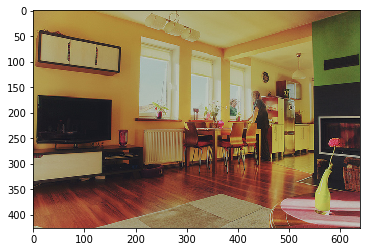

In [56]:
img = x.squeeze().permute(1,2,0).cpu().numpy()
plt.imshow(img)
#img.shape

In [ ]:
img1 = result.copy()
for i in range(GT_num):
    result[img1 == i] = GT_list[i]
result = np.uint8(result)

In [72]:
np.unique(result)

array([ 3,  5,  6, 10, 13, 15, 17, 19, 21, 22, 23, 24])

In [75]:
if args["ZSL"] is True:
    img1 = result.copy()
    for i in range(GT_num):
        result[img1 == i] = GT_list[i]
result = np.uint8(result)

In [ ]:
    # iteration over the batches
    for batch_id, data in enumerate(testloader):
        # make batch tensor and target tensor
        input = data['input']

        if USE_CUDA:
            input = input.cuda()

        # predictions
        output = model(input)

        # output segmentation_img
        filename = os.path.basename(
            testloader.dataset.get_filename(batch_id)[0])
        filename = filename.split(".")[0]
        filename = filename + ".png"
        print(filename)
        single_output = output[0, :, :, :]
        single_output = single_output.transpose(0, 1).transpose(1, 2)
        result = min_euclidean(single_output, v_array).cpu().numpy()
        if args["ZSL"] is True:
            img1 = result.copy()
            for i in range(GT_num):
                result[img1 == i] = GT_list[i]
        result = np.uint8(result)

        Image.fromarray(result).save(
            os.path.join(args["output_dir"], filename))
